In [ ]:
"""SMOTE is not implemented properly, train on oversampled data, validate on original data ratio"""

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from scipy.stats import spearmanr

import time
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import utils

In [2]:
# df_train = utils.read_pickles('../data/input/smote')

df_train = pd.read_csv('../data/train.csv')
target = df_train.pop('target')
df_train.drop(['ID_code'],axis=1,inplace=True)

In [4]:
df_train.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
# test_file = '../data/input/test.csv'
test_file = '../data/test.csv'

df_test = pd.read_csv(test_file)
test_id = df_test.pop('ID_code')

In [7]:

params = {'num_leaves': 9,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [12]:
%%time
fold_n=3

folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=30)
y_pred_lgb = np.zeros(len(df_test))
oof = np.zeros(len(df_train))
feature_importance_df = pd.DataFrame()
features = list(df_train.columns)

for fold_, (train_index, valid_index) in enumerate(folds.split(df_train, target)):
    print('Fold', fold_, 'started at', time.ctime())
    X_train, X_valid = df_train.iloc[train_index], df_train.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params, train_data, num_boost_round=10000,
                    valid_sets = [train_data, valid_data], verbose_eval = 1000, early_stopping_rounds = 100)
    
    oof[valid_index] = lgb_model.predict(df_train.iloc[valid_index], num_iteration = lgb_model.best_iteration)
    
    y_pred_lgb += lgb_model.predict(df_test, num_iteration = lgb_model.best_iteration)/fold_n
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.89719 


In [13]:
submission_lgb = pd.DataFrame({
        "ID_code": test_id,
        "target": y_pred_lgb
    })
submission_lgb.to_csv('../results/submission_lgb.csv', index=False)

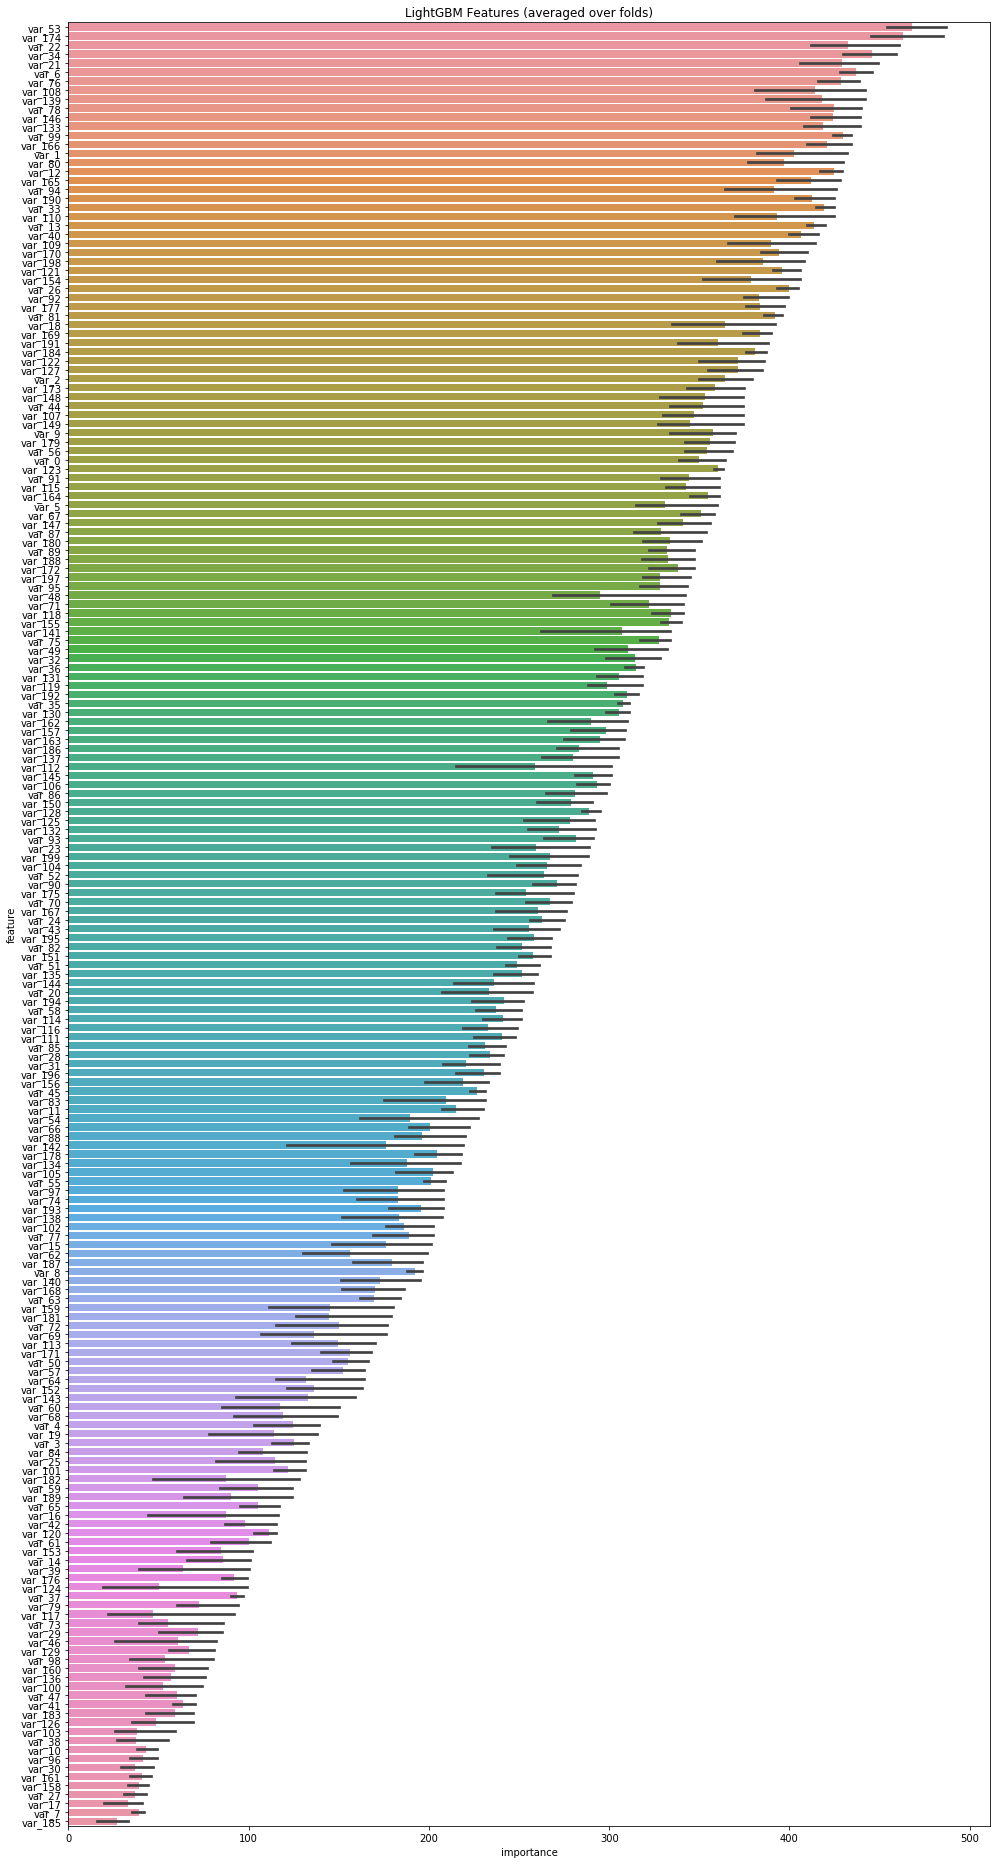

In [14]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
plt.show()